In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd

from tqdm import tqdm_notebook as tqdm

from nltk.tokenize import RegexpTokenizer

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
instances = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv')).dropna()

len(instances)

6292

 - is "cancer" present
 - is "cancer" nearby
 - are any cancer keywords within
 - was previous kw metaphorical? (maybe not)
 - keyword

In [4]:
tokenizer = RegexpTokenizer(r'\w+')

CANCER_TYPES = ["breast cancer", "lung cancer", "leukemia", "prostate cancer", "melanoma",
                 "lymphoma", "bone cancer", "skin cancer", "bladder cancer", "kidney cancer",
                 "brain cancer", "liver cancer", "pancreatic cancer", "testicular cancer",
                 "colon cancer", "cervical cancer", "esophageal cancer", "neuroblastoma"]

KEYWORDS = ['fights', 'fighting', 'fight', 'fought', 'battles', 'battled', 'battling', 'battle', 'war', 'beating', 'beats', 'beaten', 'beat', 'enemy', 'defeat', 'winning', 'win', 'path', 'journey']

In [7]:
def make_features_of_instance(ins):
    features = np.zeros(14)

    features[0] = int(ins.metaphorical)

    if "cancer" in ins.fragment.lower():
        features[1] = 1

    toked_prior = tokenizer.tokenize(ins.fragment.lower()[:int(ins.kw_start)])
    toked_post = tokenizer.tokenize(ins.fragment.lower()[int(ins.kw_start):])[1:]

    if "cancer" in toked_prior[-5:] or "cancer" in toked_post[:5]:
        features[2] = 1

    if sum(1 for ct in CANCER_TYPES if ct in ins.fragment.lower()) > 0:
        features[3] = 1

    features[4] = ins.fragment.lower().count('!')
    features[5] = ins.fragment.lower().count('?')
    features[6] = sum(1 for c in ins.fragment if c.isupper())
    features[7] = tokenizer.tokenize(ins.fragment).count('I')
    features[8] = tokenizer.tokenize(ins.fragment.lower()).count('he')
    features[9] = tokenizer.tokenize(ins.fragment.lower()).count('she')
    features[10] = tokenizer.tokenize(ins.fragment.lower()).count('they')
    features[11] = int('treatment' in ins.fragment.lower())
    features[12] = int('odds' in toked_post or 'chance' in toked_post)
    features[13] = len({'bank', 'insurance'} & set(tokenizer.tokenize(ins.fragment.lower())))
    
    features = np.concatenate([features, (np.array(KEYWORDS) == ins.keyword).astype(int)])
    
    return features

def make_features(metaphor):

    data = []

    for ins in instances.loc[instances['type'] == metaphor, :].itertuples():
        data.append(make_features_of_instance(ins))

    data = np.array(data)
    
    return data[:, 0], data[:, 1:]

In [8]:
battle_features_y, battle_features = make_features('battle')
journey_features_y, journey_features = make_features('journey')

battle_features.shape, journey_features.shape

((5262, 32), (1030, 32))

In [ ]:
from allennlp.commands.elmo import ElmoEmbedder
from sklearn.model_selection import StratifiedKFold, train_test_split

from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.callbacks import EarlyStopping

from sklearn import metrics

from datetime import datetime

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

In [10]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [11]:
battle_fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in instances.loc[instances['type'] == 'battle', ['fragment', 'kw_start']].itertuples()]

journey_fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in instances.loc[instances['type'] == 'journey', ['fragment', 'kw_start']].itertuples()]

In [12]:
elmo = ElmoEmbedder()

In [13]:
battle_embds = elmo.embed_sentences(battle_fragments)
battle_embedded_fragments = np.array([embd[2] for embd in tqdm(battle_embds)])
journey_embds = elmo.embed_sentences(journey_fragments)
journey_embedded_fragments = np.array([embd[2] for embd in tqdm(journey_embds)])

In [14]:
battle_embedded_fragments.shape, journey_embedded_fragments.shape

((5262, 20, 1024), (1030, 20, 1024))

In [15]:
y_data_battle = instances.loc[instances['type'] == 'battle', 'metaphorical'].astype(int).values
y_data_journey = instances.loc[instances['type'] == 'journey', 'metaphorical'].astype(int).values

In [16]:
battle_ixs = np.arange(len(battle_embedded_fragments))
journey_ixs = np.arange(len(journey_embedded_fragments))

In [17]:
X_train_battle, X_test_battle, y_train_battle, y_test_battle = train_test_split(battle_ixs, y_data_battle, train_size=0.8, stratify=y_data_battle)
X_train_journey, X_test_journey, y_train_journey, y_test_journey = train_test_split(journey_ixs, y_data_journey, train_size=0.8, stratify=y_data_journey)

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Build Models

In [18]:
def build_model():
    # features
    features_input = Input(shape=(32, ))

    feature_out = Dense(16)(features_input)

    # fragments
    fragment_input = Input(shape=(20, 1024))

    x = Bidirectional(GRU(20, return_sequences=True))(fragment_input)
    x = Dropout(0.1)(x)
    x = Bidirectional(GRU(20))(x)

    x = Dense(20)(x)

    fragment_out = Dense(8)(x)

    # combined
    x = concatenate([feature_out, fragment_out])

    x = Dropout(0.25)(x)
    x = Dense(4)(x)

    y = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[features_input, fragment_input], outputs=[y])

## Battle Metaphor

In [44]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

histories = []

for train_ixs, val_ixs in kfold.split(X_train_battle, y_data_battle[X_train_battle]):
    combined_model = build_model()
    combined_model.reset_states()

    combined_model.compile(optimizers.Adam(), loss='binary_crossentropy')

    h = combined_model.fit([battle_features[X_train_battle[train_ixs]], battle_embedded_fragments[X_train_battle[train_ixs]]], 
                       [y_data_battle[X_train_battle[train_ixs]]],
                       validation_data=(
                           [battle_features[X_train_battle[val_ixs]], battle_embedded_fragments[X_train_battle[val_ixs]]], 
                           [y_data_battle[X_train_battle[val_ixs]]]
                       ),
                       class_weight=[10, 1],
                       epochs=10, verbose=0)
    
    histories.append([h.history['loss'], h.history['val_loss']])
    print("Fold Complete")
    
histories = np.array(histories)

Fold Complete
Fold Complete
Fold Complete
Fold Complete
Fold Complete


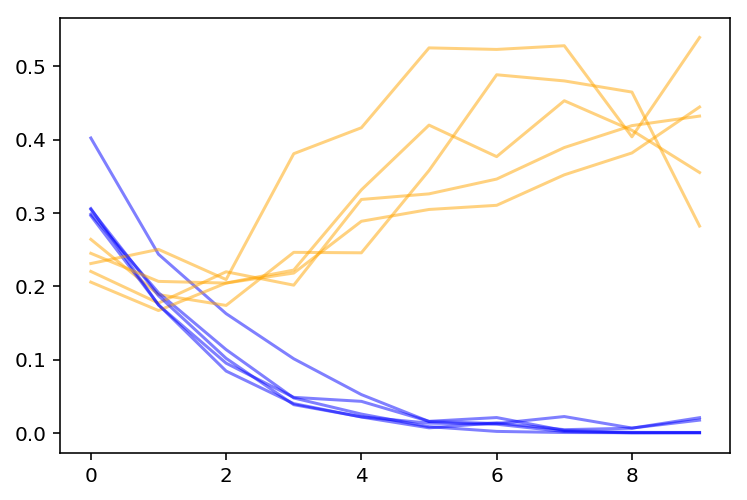

In [48]:
for sub in histories:
    plt.plot(range(10), sub[0, :], c='blue', alpha=0.5)
    plt.plot(range(10), sub[1, :], c='orange', alpha=0.5)

In [49]:
combined_model = build_model()
combined_model.reset_states()

combined_model.compile(optimizers.Adam(), loss='binary_crossentropy')

h = combined_model.fit([battle_features[X_train_battle], battle_embedded_fragments[X_train_battle]], 
       [y_data_battle[X_train_battle]],
       class_weight=[10, 1],
       epochs=3, verbose=1)

Epoch 1/3
4209/4209 [==============================] - 33s 8ms/step - loss: 0.3097
Epoch 2/3
4209/4209 [==============================] - 12s 3ms/step - loss: 0.1917
Epoch 3/3
4209/4209 [==============================] - 12s 3ms/step - loss: 0.1093


In [50]:
preds = (combined_model.predict([battle_features[X_test_battle], battle_embedded_fragments[X_test_battle]]) > 0.5).astype(int)
metrics.cohen_kappa_score(y_data_battle[X_test_battle], preds)


0.5453194650817236

In [51]:
combined_model.save('combined_battle_model.h5')

## Journey Metaphor

In [35]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

histories = []

for train_ixs, val_ixs in kfold.split(X_train_journey, y_data_journey[X_train_journey]):
    combined_model = build_model()
    combined_model.reset_states()

    combined_model.compile(optimizers.Adam(), loss='binary_crossentropy')

    h = combined_model.fit([journey_features[X_train_journey[train_ixs]], journey_embedded_fragments[X_train_journey[train_ixs]]], 
                       [y_data_journey[X_train_journey[train_ixs]]],
                       validation_data=(
                           [journey_features[X_train_journey[val_ixs]], journey_embedded_fragments[X_train_journey[val_ixs]]], 
                           [y_data_journey[X_train_journey[val_ixs]]]
                       ),
                       class_weight=[10, 1],
                       epochs=10, verbose=0)
    
    histories.append([h.history['loss'], h.history['val_loss']])
    print("Fold Complete")
    
histories = np.array(histories)

Fold Complete
Fold Complete
Fold Complete
Fold Complete
Fold Complete


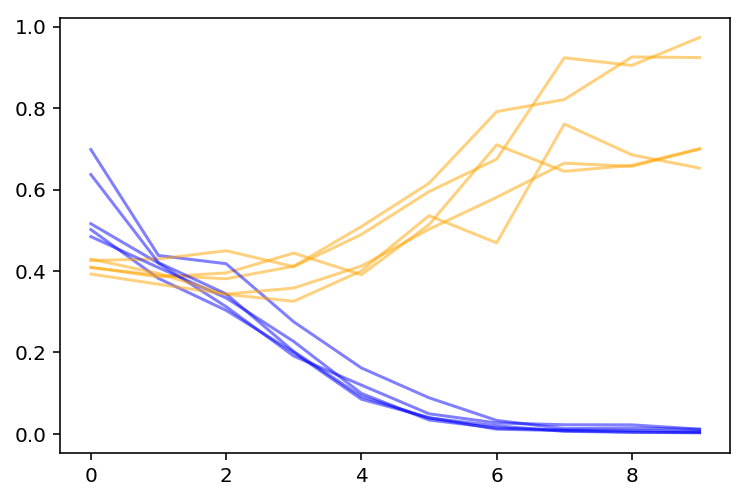

In [36]:
for sub in histories:
    plt.plot(range(10), sub[0, :], c='blue', alpha=0.5)
    plt.plot(range(10), sub[1, :], c='orange', alpha=0.5)

In [41]:
combined_model = build_model()
combined_model.reset_states()

combined_model.compile(optimizers.Adam(), loss='binary_crossentropy')

h = combined_model.fit([journey_features[X_train_journey], journey_embedded_fragments[X_train_journey]], 
       [y_data_journey[X_train_journey]],
       class_weight=[10, 1],
       epochs=5, verbose=1)

Epoch 1/5
824/824 [==============================] - 11s 13ms/step - loss: 0.4720
Epoch 2/5
824/824 [==============================] - 2s 2ms/step - loss: 0.3990
Epoch 3/5
824/824 [==============================] - 2s 2ms/step - loss: 0.3082
Epoch 4/5
824/824 [==============================] - 2s 2ms/step - loss: 0.1934
Epoch 5/5
824/824 [==============================] - 2s 2ms/step - loss: 0.0855


In [42]:
preds = (combined_model.predict([journey_features[X_test_journey], journey_embedded_fragments[X_test_journey]]) > 0.5).astype(int)
metrics.cohen_kappa_score(y_data_journey[X_test_journey], preds)


0.33131855831654344

In [43]:
combined_model.save('combined_journey_model.h5')

## Single Instance Evaluation

In [32]:
ins = pd.Series({'fragment': 'He did his best to beat the odds.',
       'keyword': 'battle',
       'kw_start': 19,
       'metaphorical': False,
       'type': 'battle'})

In [33]:
def evaluate_instance(instance):
    y = int(instance['metaphorical'])
    
    features = make_features_of_instance(instance)[1:]
    frag = elmo.embed_sentence(pad(instance['fragment'], int(instance['kw_start'])))[2]
    
    return (combined_model.predict([[features], [frag]]) > 0.5).astype(int)
    
evaluate_instance(ins)[0][0] == ins['metaphorical']

True